# we will attempt to build a bigram langauge model that generates names

In [55]:
# import names text file as dataset
names = open('names.txt').read().splitlines()
names[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [56]:
# create vocab list
vocab = sorted(list(set(''.join(names))))

# create tokenizer encoder
stoi = {}
# make the model hallucinate a start token so that we can propmt it to generate a name
# stoi is String TO Integer
stoi['.'] = 0
stoi.update({s:i+1 for i, s in enumerate(vocab)})

# create tokenizer decoder
# itos is Integer TO String
itos = {}
# make the model hallucinate an end token so that it knows when to end the name during generation
itos[0] = '.'
itos.update({i+1:s for i, s in enumerate(vocab)})
print(stoi)

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


In [3]:
import torch

# initialize count matrix with zeros, as many rows and columns as there are unique characters in the vocab - 27
N = torch.zeros(27, 27, dtype=torch.int32)
for word in names:
    chs = list(word)
    # add start and end token to every name
    word = ['.'] + chs + ['.']
    # zip together a letter with its subsequent character in the name, 
    # find the corresponding tokenized value for both characters and append by 1 because these pair of characters occurred once together
    for ch, chn in zip(word, word[1:]):
        idx1 = stoi[ch]
        idx2 = stoi[chn]
        N[idx1, idx2] += 1

# visualize the count matrix

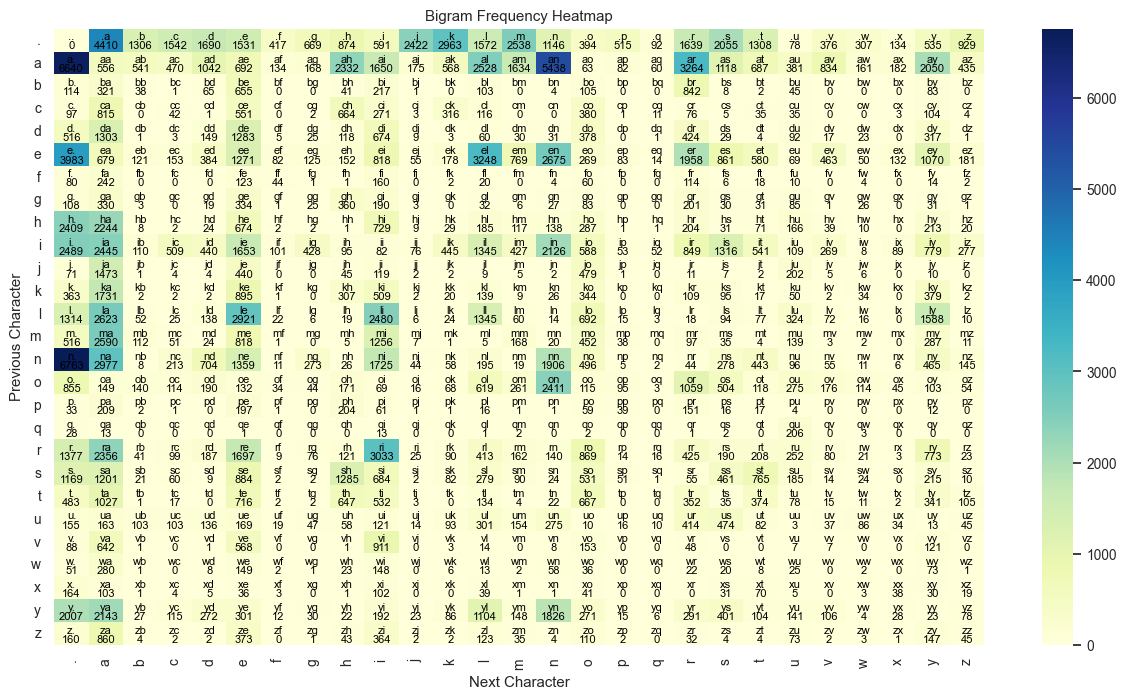

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming N is your bigram frequency matrix and stoi is your character-to-index dictionary
# Create the list of characters from the stoi dictionary
characters = list(stoi.keys())

# Set up the plot
plt.figure(figsize=(15, 8))
sns.set(font_scale=0.9)

# Create a heatmap without annotations and with a lighter colormap
ax = sns.heatmap(N, annot=False, fmt="d", cmap="YlGnBu", xticklabels=characters, yticklabels=characters)

# Set axis labels and title
ax.set_xlabel('Next Character')
ax.set_ylabel('Previous Character')
plt.title('Bigram Frequency Heatmap')

# Adding bigram text and count inside the heatmap cells
for i in range(len(characters)):
    for j in range(len(characters)):
        # Create the bigram (combination of previous and next character)
        bigram = f"{characters[i]}{characters[j]}"
        # Get the count value from the bigram frequency matrix N
        count = N[i, j].item()  # Convert to integer if needed
        
        # Annotate the heatmap with both the bigram and the count
        ax.text(j + 0.5, i + 0.35, bigram, ha='center', va='center', color='black', fontsize=8)  # Bigram on top
        ax.text(j + 0.5, i + 0.75, count, ha='center', va='center', color='black', fontsize=8)   # Count below

# Rotate the axis labels if necessary for better readability
plt.xticks(rotation=90)
plt.yticks(rotation=0)

# Show the plot
plt.show()

### first row shows how often a name starts with a particular character
### first column shows how often a name ends with a particular character

In [5]:
p = N[0].float()
p /= p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

## perform model smoothing by adding 1 to all elements of count matrix
### this is _necessary_ because a pair of characters that never occur together have probability 0, and this creates a 0 loss value for our negative log likelihood which creates issues later on

### the params in the func sum: sum(1, keepdims=True) are crucial for the correct implementation

In [6]:
P = (N+1).float() # model smoothing
print(P.shape, P.sum(1, keepdim=True).shape)
# divide each number by the sum of its entire row to obtain probabilities
P /= P.sum(1, keepdim=True) # normalize counts to probabilities so we can sample them
P[0].sum() # should sum up to 1, first row indicates probabilities of each 

torch.Size([27, 27]) torch.Size([27, 1])


tensor(1.)

### keepdim=True ensures that the dimension over which we sum is retained and not removed. this ensures correct division later on

# generate names using multinomial sampling

In [7]:
# trigger generation with the starting token
ix = 0
# adding a generator for reproducibility
g = torch.Generator().manual_seed(42)
for i in range(10):
    out = []
    while True:
        # pluck out row of corresponding letter which includes probabilities of what character will follow it
        p = P[ix]
        # sample from a multinomial distribution
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        # if end token generated, exit loop and start generating new name
        if ix == 0:
            break

    print(''.join(out))

anugeenvi.
s.
mabidushan.
stan.
silaylelaremah.
li.
le.
epiachalen.
diza.
k.


# generates names using random sampling
### this helps provide a baseline for us since even the multinomial sampling generation gives names that are not that good, but given this baseline, we can tell that its definitely working. random sampling generates pure gibberish

In [8]:
ix = 0
g = torch.Generator().manual_seed(42)
for i in range(10):
    out = []
    while True:
        p = P[ix]
        ix = torch.randint(0, 27, (1,), generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break

    print(''.join(out))

fwgvibgwmbmvhirdtdcvdzanhdkiaalcgpqybnaublallqnm.
burjryvaneututyiwxjgyq.
pggbujzwxmtcvtprkavtuoytygezpcrwvoiaylxifietbgiiwmhbdcuq.
zghwvpmhs.
aqikkvwbhagjnivumcdfybqdlahwkfnazxncve.
odbnrmvphrgbiecjdfbzjqpzsnxfcacerpfmtceabbgvlrkfjbqqoduxhldxlfvf.
qhfjszdtuytyiinfkzipymdzlhlefxffcjlfpyewsoonshcpyciwjbenjydqvnhrrzklrt.
ndcjmacsermzfjvcccraurnukkmagiysqsviqsojfrqwmg.
qnugiwizskssavimwd.
fayaei.


### calculate negative log likelihood loss for word emma

In [9]:
ll = 0
n = 0
for word in ['emma']:
    chs = list(word)
    word = ['.'] + chs + ['.']
    for ch, chn in zip(word, word[1:]):
        idx1 = stoi[ch]
        idx2 = stoi[chn]
        print(P[idx1, idx2])
        # fetch probability for corresponding pair of characters
        prob = P[idx1, idx2]
        # find log of probability and calculate sum of each of them
        ll += torch.log(prob)
        # count number of character pairs present in word 'emma'
        n += 1

# make the loss negative so that the objective of optimization is to minimize and not maximize
print(ll)
nll = -1*ll
# average the loss
nll_batch = nll/n
print(f'negative log likelihood loss: {nll_batch}')

tensor(0.0478)
tensor(0.0377)
tensor(0.0253)
tensor(0.3885)
tensor(0.1958)
tensor(-12.5716)
negative log likelihood loss: 2.5143284797668457


# so far we used the bigram count matrix as our "weight" matrix for prediction

---

# now we will train a one layer MLP to generate names

In [ ]:
# create dataset for one name
xs, ys = [], []

for word in names[:1]:
    chs = list(word)
    word = ['.'] + chs + ['.']
    for ch, chn in zip(word, word[1:]):
        idx1 = stoi[ch]
        idx2 = stoi[chn]
        print(ch, chn)
        xs.append(idx1)
        ys.append(idx2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
print(xs, ys)

. e
e m
m m
m a
a .
tensor([ 0,  5, 13, 13,  1]) tensor([ 5, 13, 13,  1,  0])


In [26]:
import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes=27).float()
xenc.shape

torch.Size([228146, 27])

In [29]:
print(f". (CLS token): {xenc[0]}")
print(f"e: {xenc[1]}")
print(f"m: {xenc[2]}")
print(f"m: {xenc[3]}")
print(f"a: {xenc[4]}")

. (CLS token): tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])
e: tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])
m: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])
m: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])
a: tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [45]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), requires_grad=True)
W.is_leaf # because its at the start of the computation graph, it was directly initialized and wasn't created through backprop

True

In [46]:
(xenc @ W).shape

torch.Size([228146, 27])

In [47]:
xenc = F.one_hot(xs, num_classes=27).float()
# xenc @ W basically plucks out the row of W where xenc is 1
logits = xenc @ W
counts = logits.exp()
probs = counts/counts.sum(1, keepdim=True)
probs

tensor([[0.0378, 0.0326, 0.0377,  ..., 0.0158, 0.1341, 0.0124],
        [0.0428, 0.0049, 0.0550,  ..., 0.0410, 0.0113, 0.0038],
        [0.0343, 0.0253, 0.0169,  ..., 0.0223, 0.0157, 0.0181],
        ...,
        [0.0199, 0.0708, 0.0509,  ..., 0.0252, 0.0249, 0.0054],
        [0.0136, 0.0172, 0.0236,  ..., 0.0230, 0.0289, 0.0122],
        [0.0376, 0.0259, 0.0279,  ..., 0.0288, 0.0067, 0.0499]],
       grad_fn=<DivBackward0>)

In [48]:
# logits = xenc @ W
# torch.softmax(logits, 1)

In [49]:
probs.shape

torch.Size([228146, 27])

In [50]:
# create train and test data for all names
xs, ys = [], []

for word in names:
    chs = list(word)
    word = ['.'] + chs + ['.']
    for ch, chn in zip(word, word[1:]):
        idx1 = stoi[ch]
        idx2 = stoi[chn]
        xs.append(idx1)
        ys.append(idx2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print(f"number of bigram examples: {num}")

number of bigram examples: 228146


Epoch: 0, loss: 3.6383423805236816
Epoch: 10, loss: 2.6759607791900635
Epoch: 20, loss: 2.5742573738098145
Epoch: 30, loss: 2.5319406986236572
Epoch: 40, loss: 2.5106863975524902
Epoch: 50, loss: 2.497962474822998
Epoch: 60, loss: 2.4894700050354004
Epoch: 70, loss: 2.4834673404693604
Epoch: 80, loss: 2.4790635108947754
Epoch: 90, loss: 2.475734233856201


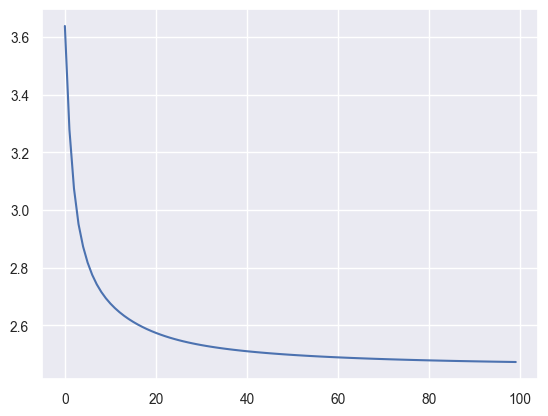

In [ ]:
# to trach loss values across epochs for plotting purposes
loss_values = []

# training loop
for i in range(100):
    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W
    # performing softmax (to obtain probabilities) in the next two lines of code
    counts = logits.exp()
    probs = counts/counts.sum(1, keepdim=True)

    # calculating NLL
    # probs[torch.arange(num), ys]: torch.arange basically runs through entire dataset plucking out one row at a time, 
    # and ys picks the correct character whose probability we ideally want to be 1, 
    # and the goal is to minimze these values (owing to the negative of NLL)
    loss = -1 * torch.log(probs[torch.arange(num), ys]).mean()
    # show updates only after every 10 epochs
    if i % 10 == 0:
        print(f"Epoch: {i}, loss: {loss.item()}")
    loss_values.append(loss.item())

    # backward pass
    W.grad = None
    loss.backward()

    # gradient update
    W.data += -50 * W.grad

plt.plot(loss_values, label='Loss Value')

In [35]:
# run inference on initial model
ix = 0
g = torch.Generator().manual_seed(2147483647)
for i in range(5):
    out = []
    while True:
        # before
        p = P[ix]

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break

    print(''.join(out))

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.


In [21]:
# run inference
ix = 0
g = torch.Generator().manual_seed(2147483647)
for i in range(5):
    out = []
    while True:
        # now (using NNs)
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W
        # counts = logits.exp()
        # p = counts / counts.sum(1, keepdim=True)
        p = torch.softmax(logits, dim=1)

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break

    print(''.join(out))

cexze.
momasurailezityha.
konimittain.
llayn.
ka.
